In [1]:
import os
import folium
import random
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from shapely.geometry import Polygon, Point

In [2]:
bikes = pd.read_csv('../cleaned_data/removed_abnormal.csv')
if 'Unnamed: 0' in bikes.columns:
    bikes.drop('Unnamed: 0', axis = 1)

In [3]:
inbikes = bikes[bikes['LOCK_STATUS'] == 1]
outbikes = bikes[bikes['LOCK_STATUS'] == 0]
fences = pd.read_csv('../cleaned_data/fence_position.csv')
fences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14071 entries, 0 to 14070
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FENCE_ID     14071 non-null  object 
 1   LONGITUDE_0  14071 non-null  float64
 2   LATITUDE_0   14071 non-null  float64
 3   LONGITUDE_1  14071 non-null  float64
 4   LATITUDE_1   14071 non-null  float64
 5   LONGITUDE_2  14071 non-null  float64
 6   LATITUDE_2   14071 non-null  float64
 7   LONGITUDE_3  14071 non-null  float64
 8   LATITUDE_3   14071 non-null  float64
 9   LONGITUDE_4  14071 non-null  float64
 10  LATITUDE_4   14071 non-null  float64
 11  LATITUDE     14071 non-null  float64
 12  LONGITUDE    14071 non-null  float64
 13  ROAD         14071 non-null  object 
 14  AREA         14071 non-null  float64
 15  FID          14071 non-null  int64  
dtypes: float64(13), int64(1), object(2)
memory usage: 1.7+ MB


In [4]:
in_outliers = inbikes[(inbikes['NEAREST_FENCE'] == -1) | (inbikes['DISTANCE'] > 30)]
out_outliers = outbikes[(outbikes['NEAREST_FENCE'] == -1)|(outbikes['DISTANCE'] > 30)]
# inbikes = inbikes[(inbikes['NEAREST_FENCE'] != -1) & (inbikes['DISTANCE'] <= 30)]
# outbikes = outbikes[(outbikes['NEAREST_FENCE'] != -1) & (outbikes['DISTANCE'] <= 30)]
inbikes = inbikes[(inbikes['NEAREST_FENCE'] != -1) & (inbikes['DISTANCE'] <= 30) & (inbikes['DISTANCE'] > 0)]
outbikes = outbikes[(outbikes['NEAREST_FENCE'] != -1) & (outbikes['DISTANCE'] <= 30)& (outbikes['DISTANCE'] > 0)]

In [5]:
bikes_in = pd.merge(inbikes,fences, left_on='NEAREST_FENCE', right_on='FID',how='left')
bikes_in.drop('NEAREST_FENCE', axis = 1, inplace = True)
bikes_out = pd.merge(outbikes,fences, left_on='NEAREST_FENCE', right_on='FID',how='left')
bikes_out.drop('NEAREST_FENCE', axis = 1, inplace = True)

In [6]:
in_fence_flow = bikes_in.groupby('FID').agg({'FID':'count'})
out_fence_flow = bikes_out.groupby('FID').agg({'FID':'count'})

In [7]:
in_fence_flow.columns = ["IN_CNT"]
in_fence_flow['FID'] = in_fence_flow.index
in_fence_flow.index = in_fence_flow.index.rename('new name')
out_fence_flow.columns = ["OUT_CNT"]
out_fence_flow['FID'] = out_fence_flow.index
out_fence_flow.index = out_fence_flow.index.rename('new name')

In [8]:
dfs = [fences, in_fence_flow, out_fence_flow]
in_out_df = pd.merge(fences, in_fence_flow, left_on = 'FID', right_on = 'FID', how = 'left')
in_out_df = pd.merge(in_out_df, out_fence_flow, left_on = 'FID', right_on = 'FID', how = 'left')

In [9]:
in_out_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14071 entries, 0 to 14070
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FENCE_ID     14071 non-null  object 
 1   LONGITUDE_0  14071 non-null  float64
 2   LATITUDE_0   14071 non-null  float64
 3   LONGITUDE_1  14071 non-null  float64
 4   LATITUDE_1   14071 non-null  float64
 5   LONGITUDE_2  14071 non-null  float64
 6   LATITUDE_2   14071 non-null  float64
 7   LONGITUDE_3  14071 non-null  float64
 8   LATITUDE_3   14071 non-null  float64
 9   LONGITUDE_4  14071 non-null  float64
 10  LATITUDE_4   14071 non-null  float64
 11  LATITUDE     14071 non-null  float64
 12  LONGITUDE    14071 non-null  float64
 13  ROAD         14071 non-null  object 
 14  AREA         14071 non-null  float64
 15  FID          14071 non-null  int64  
 16  IN_CNT       11590 non-null  float64
 17  OUT_CNT      10250 non-null  float64
dtypes: float64(15), int64(1), object(2)
memory usa

In [10]:
in_out_df.fillna(0, inplace = True)

In [11]:
in_out_df['FLOW'] = in_out_df.apply(lambda x: x['IN_CNT'] - x['OUT_CNT'], axis = 1)
in_out_df['FLOW_DENSITY'] = in_out_df.apply(lambda x: (x['IN_CNT'] - x['OUT_CNT'])/x['AREA'], axis = 1)

In [12]:
sorted_df = in_out_df.sort_values(by=['FLOW'], ignore_index = True, ascending = False)

In [13]:
top_300_fences = sorted_df['FID'].values[:200]
top_300_la = sorted_df['LATITUDE'].values[:200]
top_300_lo = sorted_df['LONGITUDE'].values[:200]

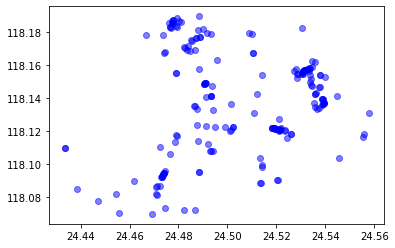

In [14]:
plt.scatter(x = top_300_la, y = top_300_lo, alpha = 0.5, color = 'blue')

In [15]:
points = [(x1, x2) for x1, x2 in zip(top_300_la, top_300_lo)]
print(len(points))
m = folium.Map(location=[24.527352, 118.10321675], zoom_start=13, zoom_control='False',
               attr='AutoNavi')
for point in points:
    folium.Marker(point).add_to(m)
m

200


In [16]:
fence_cluster = DBSCAN(eps = 0.0006, min_samples = 1).fit_predict(points)

In [17]:
len(collections.Counter(fence_cluster))

123

In [18]:
fence_cluster

array([  0,   1,   2,   3,   2,   4,   5,   1,   6,   7,   8,   9,  10,
        11,  12,  11,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
         4,  23,  24,  25,  26,  12,  27,  18,  13,  28,  19,  26,  29,
        18,  12,  30,  31,   1,  32,  33,  31,   8,  34,  35,  36,  37,
        38,  19,  31,  31,  31,  39,  30,  18,  40,  41,  13,  42,  43,
        44,  45,   1,  46,  47,  48,  49,  50,  24,  51,  49,  52,  53,
        54,  55,   1,  11,  36,  56,  57,  31,  58,  59,   6,  60,   1,
        61,  62,  44,  13,  11,   5,  40,  59,  13,  50,  30,  63,  59,
        64,  38,  65,  66,  67,  68,  18,  69,  44,  70,  20,  71,  11,
        72,  73,  74,  73,  75,  76,  77,  13,  78,  79,  80,   1,  81,
        12,  82,  83,  84,  15,  85,  86,  17,  13,  87,  13,  37,  88,
        89,  71,  90,  70,  91,  26,  92,  50,  93,  94,  95,  96,  97,
        98,  80,  99, 100,  25, 101, 102,  44, 103,  40,  13,  96, 104,
       105, 106, 107,  11, 108,  32, 109, 110, 111,  68, 112,  2

In [19]:
def export_res(keys, fname, fences_df):
    f = open(fname, 'w', encoding = 'utf-8')
    f.writelines('FENCE_ID|FENCE_TYPE|BELONG_AREA')
    f.write('\n')
    for i in range(len(fences_df)):
        fence_id = fences_df['FENCE_ID'][i]
        fen = fences_df['FID'][i]
        if fen in keys:
            is_crowded = 1
        else:
            is_crowded = 0
        string = fence_id + '|' + str(is_crowded) + '|' + str(is_crowded)
        f.writelines(string)
        f.write('\n')
    f.close()

In [20]:
export_res(top_300_fences, '../result.txt', fences)
# top 200 flow density: 18.75

In [21]:
f = pd.read_csv('../result.txt', sep = '|')
sum(f['FENCE_TYPE'])

200